In [1]:
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
import random
import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

from PIL import Image
import os, json
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data

In [2]:
train_image_folder = '../input/cassava-leaf-disease-classification/train_images/'
total = len(list(pathlib.Path(train_image_folder).glob("*.jpg")))
print(f"Total Training Images - {total}")

Total Training Images - 21397


In [3]:
# Class Labels
with open("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", "r") as f:
    json_data = f.read()
    json_data = json.loads(json_data)
print(json.dumps(json_data, indent=4, sort_keys=True))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [4]:
df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
# df = shuffle(df, random_state=42)
df['filepath'] = df.image_id.apply(lambda x : train_image_folder+x)
df['class_name'] = df.label.apply(lambda x : json_data[str(x)])

df.head()

image_id  label                                           filepath  \
0  1000015157.jpg      0  ../input/cassava-leaf-disease-classification/t...   
1  1000201771.jpg      3  ../input/cassava-leaf-disease-classification/t...   
2   100042118.jpg      1  ../input/cassava-leaf-disease-classification/t...   
3  1000723321.jpg      1  ../input/cassava-leaf-disease-classification/t...   
4  1000812911.jpg      3  ../input/cassava-leaf-disease-classification/t...   

                            class_name  
0       Cassava Bacterial Blight (CBB)  
1         Cassava Mosaic Disease (CMD)  
2  Cassava Brown Streak Disease (CBSD)  
3  Cassava Brown Streak Disease (CBSD)  
4         Cassava Mosaic Disease (CMD)

In [5]:
# Total Image Count By Class
df['class_name'].value_counts()

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: class_name, dtype: int64

## Data Viz

- dividing data into traing and validation set (here we have used 80% for traning and 20% for validation)

In [6]:
total_images = len(df)
train_data_size = int(total_images * 0.8)
test_data_size = total_images - train_data_size

shuffled_df = shuffle(df, random_state=42)

train_df = shuffled_df.iloc[:train_data_size]
test_df = shuffled_df.iloc[train_data_size:]

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

# print(train_data_size, validation_data_size)
print(f"Total Training Images - {train_data_size}")
print(f"Total Test Images - {test_data_size}")

Total Training Images - 17117
Total Test Images - 4280


In [7]:
train_df.head()

image_id  label                                           filepath  \
0  2615227158.jpg      4  ../input/cassava-leaf-disease-classification/t...   
1  1277648239.jpg      3  ../input/cassava-leaf-disease-classification/t...   
2  2305895487.jpg      3  ../input/cassava-leaf-disease-classification/t...   
3   336299725.jpg      2  ../input/cassava-leaf-disease-classification/t...   
4  1951270318.jpg      2  ../input/cassava-leaf-disease-classification/t...   

                     class_name  
0                       Healthy  
1  Cassava Mosaic Disease (CMD)  
2  Cassava Mosaic Disease (CMD)  
3    Cassava Green Mottle (CGM)  
4    Cassava Green Mottle (CGM)

In [8]:
test_df.head()

image_id  label                                           filepath  \
0  2824543301.jpg      3  ../input/cassava-leaf-disease-classification/t...   
1   184909120.jpg      3  ../input/cassava-leaf-disease-classification/t...   
2  2602456265.jpg      3  ../input/cassava-leaf-disease-classification/t...   
3  1331491784.jpg      3  ../input/cassava-leaf-disease-classification/t...   
4   414363375.jpg      3  ../input/cassava-leaf-disease-classification/t...   

                     class_name  
0  Cassava Mosaic Disease (CMD)  
1  Cassava Mosaic Disease (CMD)  
2  Cassava Mosaic Disease (CMD)  
3  Cassava Mosaic Disease (CMD)  
4  Cassava Mosaic Disease (CMD)

## View Images

In [9]:
def show_batch(temp_df):
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img_path = temp_df.iloc[n]['filepath']
        img = Image.open(img_path)
        plt.imshow(img)
#         plt.title(temp_df.iloc[n]['class_name'])
        plt.axis('off')

#### Healthy Images

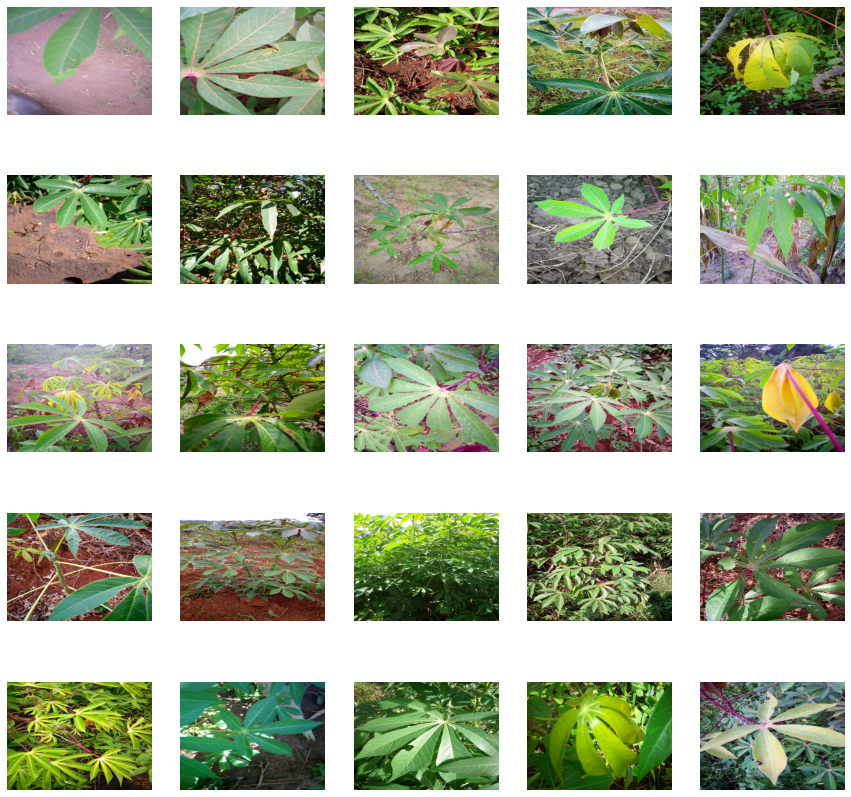

In [10]:
tdf = train_df[train_df['class_name']=="Healthy"]
show_batch(tdf)
# print(tdf.shape)

#### Cassava Bacterial Blight (CBB)

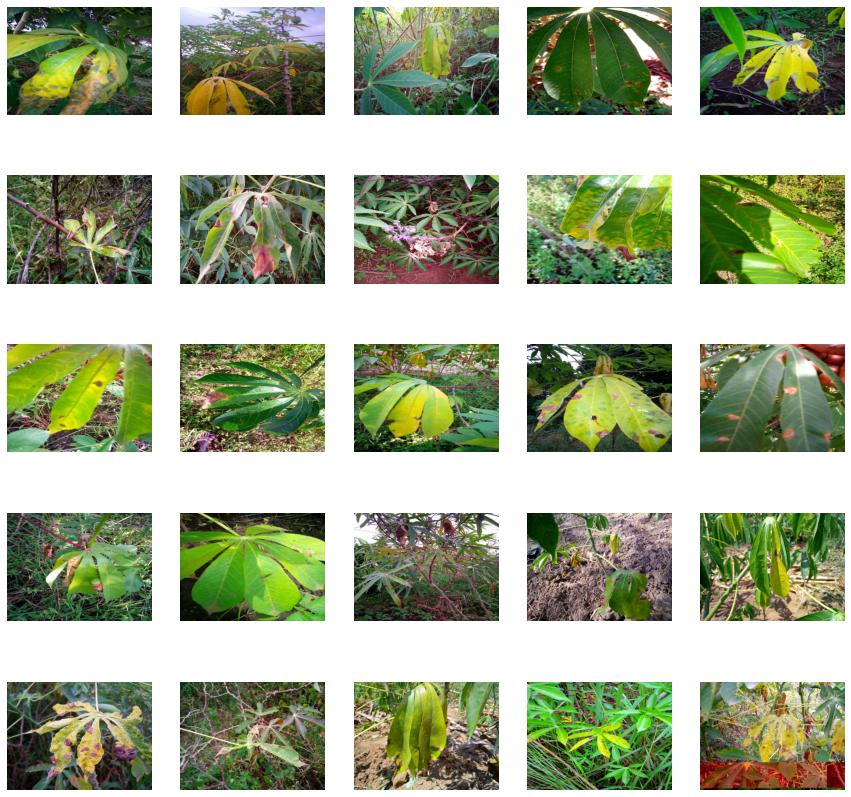

In [11]:
tdf = train_df[train_df['class_name'] == "Cassava Bacterial Blight (CBB)"]
show_batch(tdf)


#### Cassava Mosaic Disease (CMD)

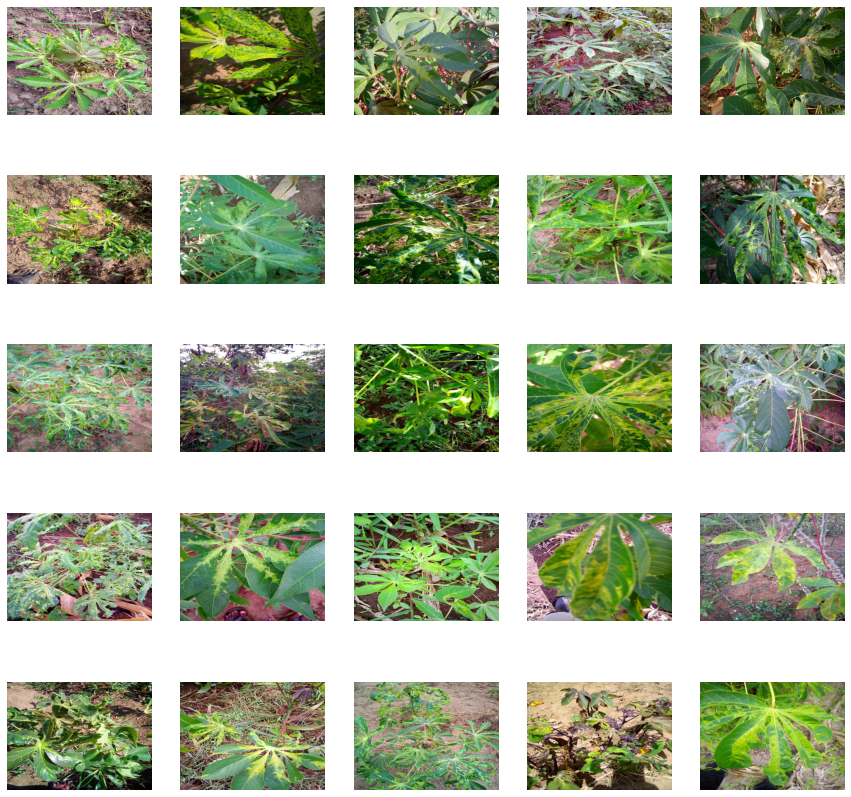

In [12]:
tdf = train_df[train_df['class_name'] == "Cassava Mosaic Disease (CMD)"]
show_batch(tdf)

#### Cassava Brown Streak Disease (CBSD)

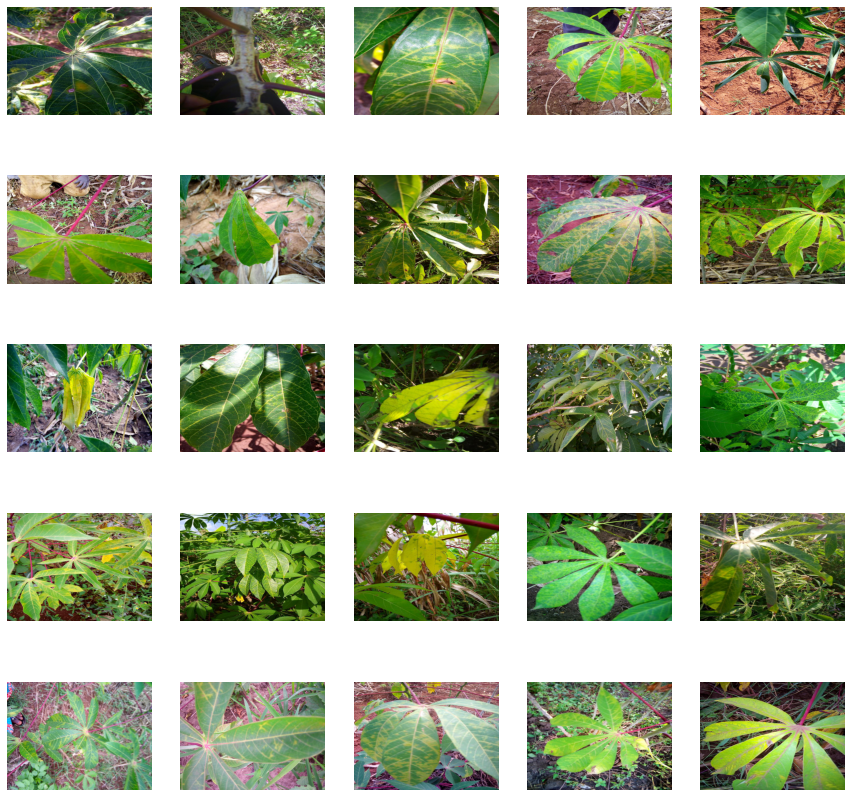

In [13]:
tdf = train_df[train_df['class_name'] == "Cassava Brown Streak Disease (CBSD)"]
show_batch(tdf)

#### Cassava Green Mottle (CGM)

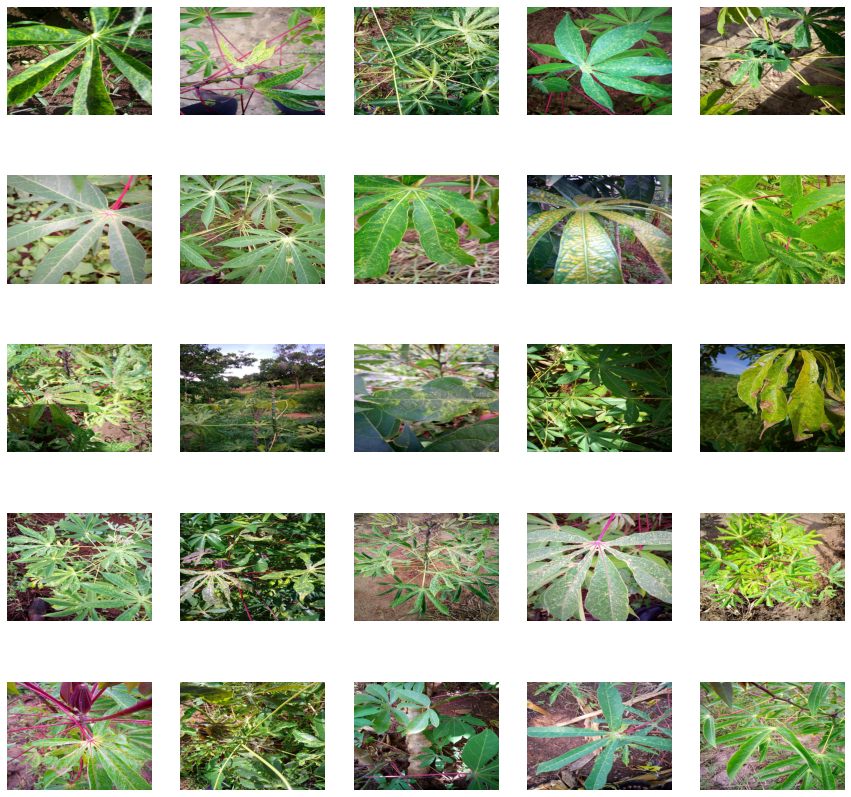

In [14]:
tdf = train_df[train_df['class_name'] == "Cassava Green Mottle (CGM)"]
show_batch(tdf)

# Data Preparation

In [15]:
BATCH_SIZE = 8
IMG_SIZE = 512
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
dropout_rate = 0.4
classes = sorted(train_df.label.unique())
print(classes)

[0, 1, 2, 3, 4]


In [16]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.filepath.values, train_df.label.values))
test_data = tf.data.Dataset.from_tensor_slices((test_df.filepath.values, test_df.label.values))

2021-11-30 00:38:26.396176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:38:26.507806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:38:26.508706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:38:26.512563: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
# for b in train_data:
#     print(type(b), b)
#     print(b[0].numpy())
#     break

In [18]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [19]:
training_batches = train_data.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_batches = test_data.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [20]:
def read_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

In [21]:
cassava_data = tf.data.Dataset.from_tensor_slices(train_df.filepath.values)

cassava_data = cassava_data.map(read_image, num_parallel_calls=AUTOTUNE)
cassava_data_batches = cassava_data.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [22]:
augmentation_layer = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=IMG_SIZE, width=IMG_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

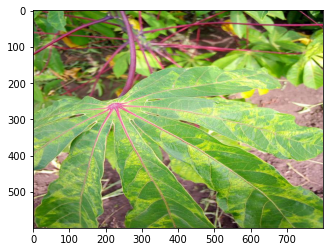

In [23]:
image = Image.open("../input/cassava-leaf-disease-classification/train_images/1001742395.jpg")
plt.imshow(image)
plt.show()

In [24]:
image = tf.expand_dims(np.array(image), 0)

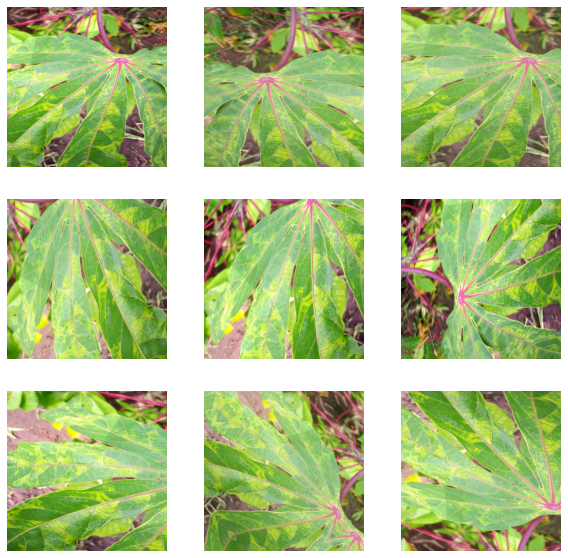

In [25]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = augmentation_layer(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Model Building

In [26]:
efficientnet = EfficientNetB3(weights="../input/efficientnetb3-notop/efficientnetb3_notop.h5", 
                              include_top=False, 
                              input_shape=INPUT_SHAPE, 
                              drop_connect_rate=dropout_rate
                             )

inputs = Input(shape=INPUT_SHAPE)
augmented_images = augmentation_layer(inputs)
efficientnet = efficientnet(augmented_images)
pooling_layer = layers.GlobalAveragePooling2D()(efficientnet)
dropout_layer = layers.Dropout(dropout_rate)(pooling_layer)
output_layer = Dense(len(classes), activation="softmax")(dropout_layer)
model = Model(inputs=inputs, outputs=output_layer)
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
____________________________________________

In [27]:
%%time
model.get_layer('efficientnetb3').get_layer('normalization').adapt(cassava_data_batches)

2021-11-30 00:38:40.532488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 2min 49s, sys: 1min, total: 3min 50s
Wall time: 2min 51s


In [28]:
epochs = 8
decay_steps = int(round(len(train_df)/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

callbacks = [ModelCheckpoint(filepath='best_model_v3.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [29]:
history = model.fit(training_batches,
                  epochs = epochs, 
                  validation_data=test_batches,
                  callbacks=callbacks)

Epoch 1/8


2021-11-30 00:41:48.561279: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2140/2140 [==============================] - 1269s 583ms/step - loss: 0.5845 - accuracy: 0.7934 - val_loss: 0.3887 - val_accuracy: 0.8671
Epoch 2/8
2140/2140 [==============================] - 1239s 578ms/step - loss: 0.4506 - accuracy: 0.8466 - val_loss: 0.5056 - val_accuracy: 0.8150
Epoch 3/8
2140/2140 [==============================] - 1243s 579ms/step - loss: 0.4004 - accuracy: 0.8640 - val_loss: 0.3699 - val_accuracy: 0.8715
Epoch 4/8
2140/2140 [==============================] - 1243s 579ms/step - loss: 0.3716 - accuracy: 0.8762 - val_loss: 0.3876 - val_accuracy: 0.8664
Epoch 5/8
2140/2140 [==============================] - 1246s 580ms/step - loss: 0.3486 - accuracy: 0.8826 - val_loss: 0.3736 - val_accuracy: 0.8729
Epoch 6/8
2140/2140 [==============================] - 1246s 580ms/step - loss: 0.3244 - accuracy: 0.8889 - val_loss: 0.3678 - val_accuracy: 0.8727
Epoch 7/8
2140/2140 [==============================] - 1248s 581ms/step - loss: 0.3071 - accuracy: 0.8945 - val_loss: 0.35

# Evaluation and Results

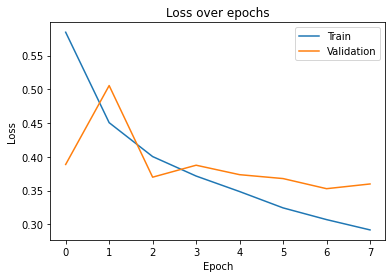

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

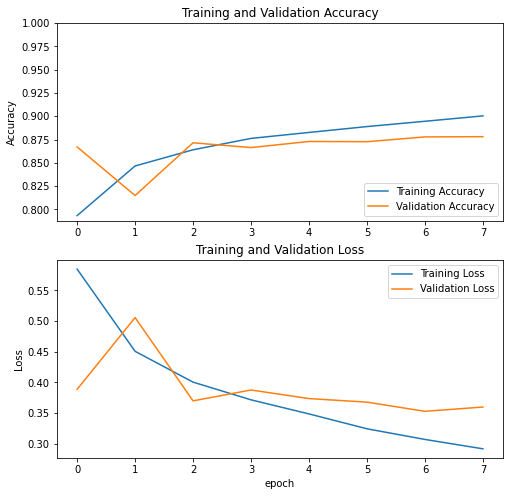

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
# model.load_weights("../input/cassava-leaf-cmpe-255-v2/my_model.h5")

## Prediction on Test Images

In [33]:
def resize_images(img_path, crop_size=512):
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height - crop_size)
    x = random.randint(0,img_width - crop_size)

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return np.array(img_list)


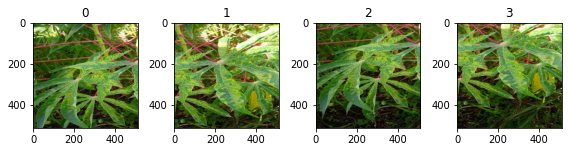

In [34]:
def display_images(img_path):
   
    img_list = resize_images(img_path)
    sample_number = len(img_list)
    fig = plt.figure(figsize = (8,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(img_list[i])
        ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

display_images("../input/cassava-leaf-disease-classification/train_images/3412658650.jpg")

In [35]:
test_augmentation_layer = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [36]:
def predict_label(image_filename, folder, TTA_runs=4):    
    localised_predictions = []
    local_image_list = resize_images(folder+image_filename)
    for local_image in local_image_list:
        duplicated_local_image = tf.convert_to_tensor(np.array([local_image for i in range(TTA_runs)]))
        augmented_images = test_augmentation_layer(duplicated_local_image)
        
        predictions = model.predict(augmented_images)
        localised_predictions.append(np.sum(predictions, axis=0))
    
    #sum all predictions from all 4 images and retrieve the index of the highest value
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)
    
    return final_prediction

In [37]:
from tqdm.notebook import tqdm

In [38]:
def get_predictions(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_label(image_filename, folder))
    return predictions

In [39]:
test_df["results"] = get_predictions(test_df["image_id"], train_image_folder)

  0%|          | 0/4280 [00:00<?, ?it/s]

In [40]:
!cat ../input/cassava-leaf-disease-classification/label_num_to_disease_map.json

{"0": "Cassava Bacterial Blight (CBB)", "1": "Cassava Brown Streak Disease (CBSD)", "2": "Cassava Green Mottle (CGM)", "3": "Cassava Mosaic Disease (CMD)", "4": "Healthy"}


In [41]:
true_positives = 0
prediction_distribution_per_class = {"0":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "1":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "2":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "3":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "4":{"0": 0, "1": 0, "2":0, "3":0, "4":0}}
number_of_images = len(test_df)
for idx, pred in test_df.iterrows():
    if int(pred["label"]) == pred.results:
        true_positives+=1
    prediction_distribution_per_class[str(pred["label"])][str(pred.results)] += 1
print("accuracy: {}%".format(true_positives/number_of_images*100))

accuracy: 88.45794392523364%


In [42]:
prediction_distribution_per_class

{'0': {'0': 127, '1': 12, '2': 5, '3': 13, '4': 68},
 '1': {'0': 18, '1': 338, '2': 15, '3': 13, '4': 47},
 '2': {'0': 7, '1': 7, '2': 395, '3': 42, '4': 15},
 '3': {'0': 3, '1': 10, '2': 46, '3': 2542, '4': 24},
 '4': {'0': 42, '1': 27, '2': 48, '3': 32, '4': 384}}

In [43]:
heatmap_df = pd.DataFrame(columns={"groundtruth","prediction","value"})
heatmap_df

Empty DataFrame
Columns: [prediction, groundtruth, value]
Index: []

<AxesSubplot:xlabel='prediction', ylabel='groundtruth'>

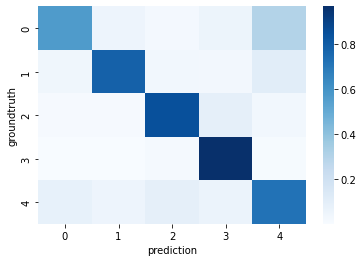

In [44]:
heatmap_df = pd.DataFrame(columns={"groundtruth","prediction","value"})
for key in prediction_distribution_per_class.keys():
    for pred_key in prediction_distribution_per_class[key].keys():
        value = prediction_distribution_per_class[key][pred_key]/test_df[test_df['label']==int(key)].count()[0]
# value = prediction_distribution_per_class[key][pred_key]/valid_df.query("label==@key").count()[0]
        heatmap_df = heatmap_df.append({"groundtruth":key,"prediction":pred_key,"value":value}, ignore_index=True)   
#         print(value)
heatmap = heatmap_df.pivot(index='groundtruth', columns='prediction', values='value')
sns.heatmap(heatmap,cmap="Blues")